<a href="https://colab.research.google.com/github/wekt2k04/digits-classification-svm-mlp/blob/main/Digits_Classification_SVM_vs_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Install necessary libraries
# We use mlxtend for plotting decision boundaries
!pip install mlxtend --quiet

In [3]:
import warnings
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_decision_regions

# Configuration for cleaner output
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="pastel")
%matplotlib inline

print("Libraries imported successfully.")

Libraries imported successfully.


Dataset loaded: 1797 samples, 64 features.
Target classes: [0 1 2 3 4 5 6 7 8 9]


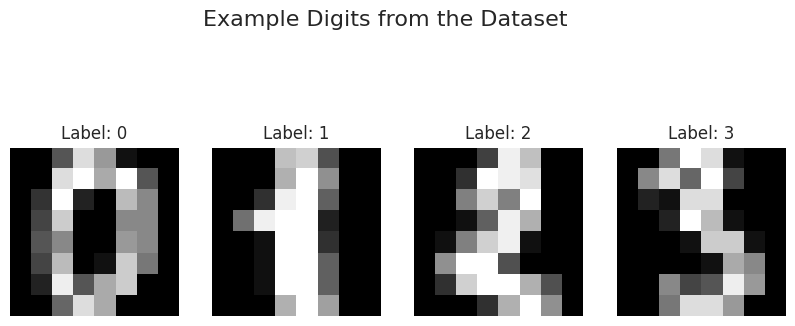

In [4]:
# 1. Data Loading
digits = load_digits()
X, y = digits.data, digits.target

print(f"Dataset loaded: {X.shape[0]} samples, {X.shape[1]} features.")
print(f"Target classes: {np.unique(y)}")

# 2. Visualization of some samples
plt.figure(figsize=(10, 4))
for index, (image, label) in enumerate(zip(digits.images[:4], digits.target[:4])):
    plt.subplot(1, 4, index + 1)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.title(f'Label: {label}', fontsize=12)
    plt.axis('off')
plt.suptitle('Example Digits from the Dataset', y=1.05, fontsize=16)
plt.show()

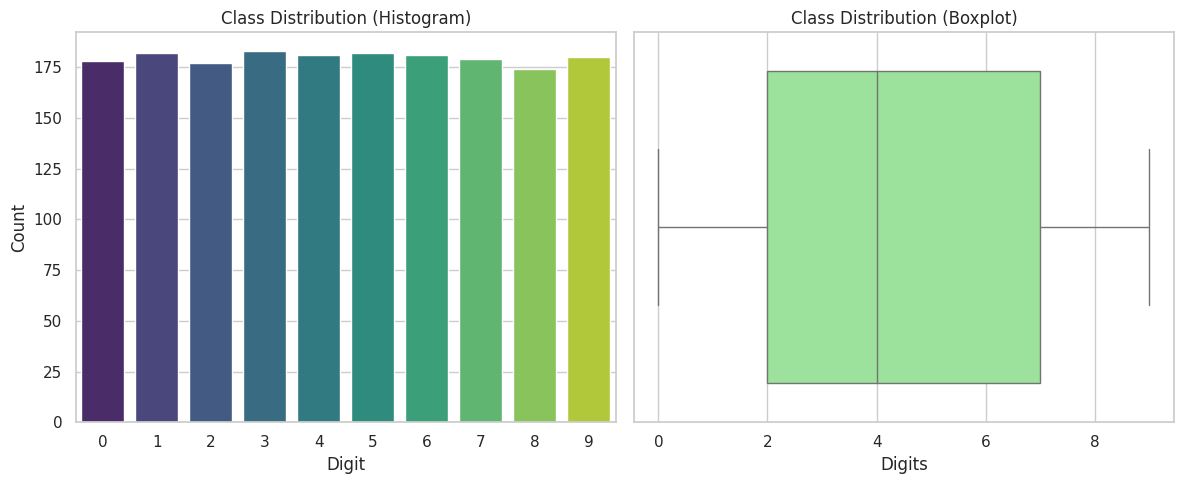

In [5]:
# 3. Class Distribution Analysis
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.countplot(x=y, palette="viridis")
plt.title("Class Distribution (Histogram)")
plt.xlabel("Digit")
plt.ylabel("Count")

# Boxplot (to check statistical balance)
plt.subplot(1, 2, 2)
sns.boxplot(x=y, color='lightgreen')
plt.title("Class Distribution (Boxplot)")
plt.xlabel("Digits")

plt.tight_layout()
plt.show()

# Insight: The dataset is well-balanced.

In [6]:
# 4. Preprocessing
# Scaling: Important for SVM and MLP
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality Reduction using PCA (to 2D for visualization)
# We reduce to 2 dimensions to enable decision boundary plotting.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (1437, 2)
Test set shape: (360, 2)


In [8]:
def plot_svc_decision_boundary(model, X, y, title):
    """Custom function to plot decision boundaries using mlxtend."""
    plt.figure(figsize=(10, 6))
    plot_decision_regions(X=X, y=y.astype(np.integer), clf=model, legend=2)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(title)
    plt.show()

def evaluate_model(y_true, y_pred, model_name):
    """Prints formatted evaluation metrics."""
    print(f"--- {model_name} Evaluation ---")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred, average='weighted'):.4f}")
    print("-" * 30)

Training SVMs with different kernels and C=1.0...
Kernel: linear     | Test Accuracy: 0.6361
Kernel: rbf        | Test Accuracy: 0.6417
Kernel: poly       | Test Accuracy: 0.6500

Best SVM Kernel: poly


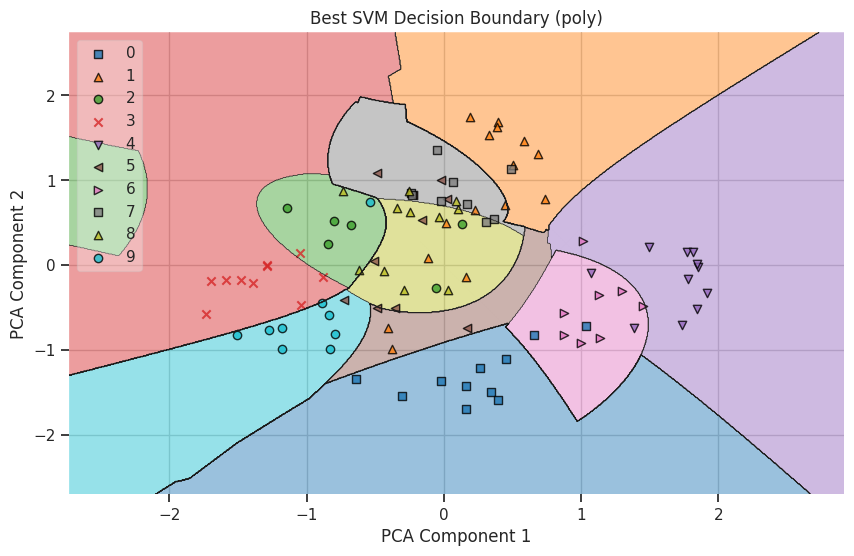

In [9]:
# 5. SVM Hyperparameter Tuning
kernels = ['linear', 'rbf', 'poly']
best_svm_model = None
best_svm_acc = 0

print("Training SVMs with different kernels and C=1.0...")

for kernel in kernels:
    # Note: For poly, we add degree=3, coef0=1 as in your report
    if kernel == 'poly':
        model = SVC(kernel=kernel, C=1.0, degree=3, coef0=1, gamma='scale', random_state=42)
    else:
        model = SVC(kernel=kernel, C=1.0, gamma='scale', random_state=42)

    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    print(f"Kernel: {kernel: <10} | Test Accuracy: {acc:.4f}")

    if acc > best_svm_acc:
        best_svm_acc = acc
        best_svm_model = model

# Visualize the best SVM model
print(f"\nBest SVM Kernel: {best_svm_model.kernel}")
plot_svc_decision_boundary(best_svm_model, X_train[:100], y_train[:100],
                           f"Best SVM Decision Boundary ({best_svm_model.kernel})")

Training MLP with different configurations...
Config: {'hidden_layer_sizes': (100,), 'solver': 'adam', 'activation': 'relu'} | Test Accuracy: 0.6639
Config: {'hidden_layer_sizes': (100,), 'solver': 'sgd', 'activation': 'relu'} | Test Accuracy: 0.6417
Config: {'hidden_layer_sizes': (50, 30), 'solver': 'adam', 'activation': 'relu'} | Test Accuracy: 0.6528


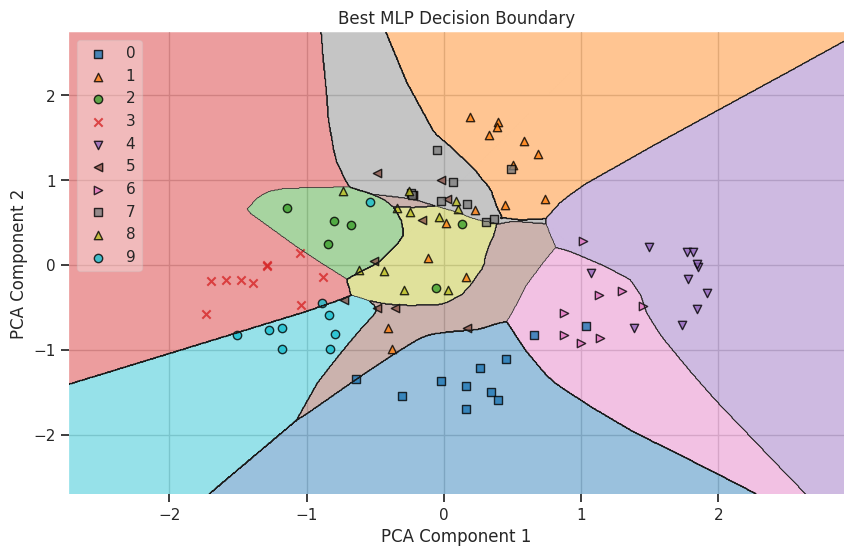

In [10]:
# 6. MLP Classifier Tuning
# Testing different architectures and solvers
configs = [
    {'hidden_layer_sizes': (100,), 'solver': 'adam', 'activation': 'relu'},
    {'hidden_layer_sizes': (100,), 'solver': 'sgd', 'activation': 'relu'},
    {'hidden_layer_sizes': (50, 30), 'solver': 'adam', 'activation': 'relu'}
]

best_mlp_model = None
best_mlp_acc = 0

print("Training MLP with different configurations...")

for config in configs:
    model = MLPClassifier(random_state=42, max_iter=1000, **config)
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)

    print(f"Config: {config} | Test Accuracy: {acc:.4f}")

    if acc > best_mlp_acc:
        best_mlp_acc = acc
        best_mlp_model = model

# Visualize the best MLP model
plot_svc_decision_boundary(best_mlp_model, X_train[:100], y_train[:100],
                           "Best MLP Decision Boundary")


FINAL RESULTS
--- Best SVM Evaluation ---
Accuracy:  0.6500
F1 Score:  0.6500
------------------------------
--- Best MLP Evaluation ---
Accuracy:  0.6639
F1 Score:  0.6549
------------------------------

Overall Winner: MLP


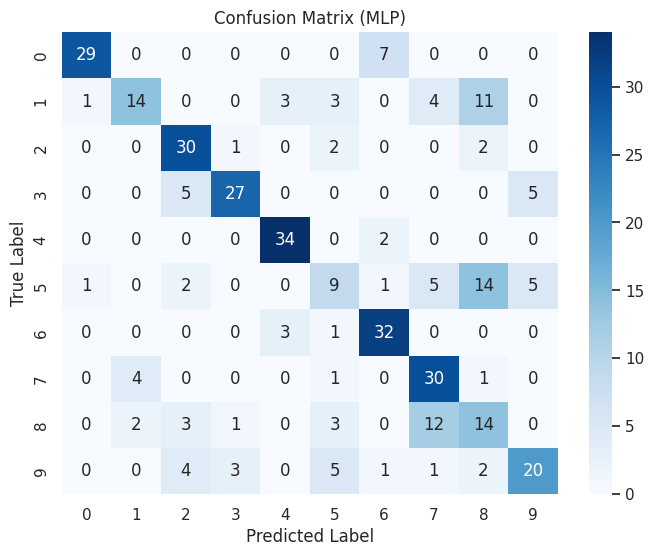

In [11]:
# 7. Final Comparison
print("\n" + "="*40)
print("FINAL RESULTS")
print("="*40)

# Predictions
y_pred_svm = best_svm_model.predict(X_test)
y_pred_mlp = best_mlp_model.predict(X_test)

evaluate_model(y_test, y_pred_svm, "Best SVM")
evaluate_model(y_test, y_pred_mlp, "Best MLP")

# Confusion Matrix for the winner
winner = "SVM" if best_svm_acc > best_mlp_acc else "MLP"
print(f"\nOverall Winner: {winner}")

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_svm if winner == "SVM" else y_pred_mlp)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Confusion Matrix ({winner})")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()